In [1]:
import rdflib
from rdflib import URIRef
from rdflib.namespace import OWL, RDF, RDFS,XSD, Namespace
import csv
from torch_geometric.data import HeteroData
import torch
import numpy as np

In [2]:
prefix = "https://dbpedia.org/ontology/"
possible_types = {}

In [3]:
def get_type(relation):
    r_split = relation.split("/")
    return r_split[len(r_split)-1]

In [4]:
def get_property_type(property):
    split_p = property.split("^^")
    p_type = str(split_p[1].split("#")[1]).lower()
    
    if p_type.startswith("xsd:integer"):
        return("Integer", split_p[0])
    if p_type.startswith("xsd:string"):
        return("String", split_p[0])
    if p_type.startswith("xsd:double"):
        return("Double", split_p[0])
    if p_type.startswith("xsd:gYear"):
        return("Year",split_p[0])
    if p_type.startswith("xsd:date"):
        return("Date",split_p[0])
    return ("","")

In [5]:
ontology = rdflib.Graph()
ontology.parse('data/external/complete.nt', format='ttl')

<Graph identifier=Ndeac9936716340cd8f33f430aac8f729 (<class 'rdflib.graph.Graph'>)>

In [6]:
ontology.bind("dbo", Namespace("http://dbpedia.org/ontology/"))
ontology.bind("dbr", Namespace("http://dbpedia.org/resource/"))
ontology.bind("rdfs", Namespace("http://www.w3.org/2000/01/rdf-schema#"))
ontology.bind("owl", Namespace("http://www.w3.org/2002/07/owl#"))
ontology.bind("rdf", Namespace("http://www.w3.org/1999/02/22-rdf-syntax-ns#"))

In [7]:
def get_possible_types(subj_type, obj_type):
    if (subj_type,obj_type) not in possible_types:
        
        q = "SELECT DISTINCT ?property WHERE {"+\
        "{ ?property rdfs:domain dbo:"+subj_type+". ?property rdfs:range dbo:"+obj_type+\
        " .} UNION {dbo:"+subj_type +" rdfs:subClassOf ?superclass. dbo:"+obj_type +" rdfs:subClassOf  ?superclass2 ."+\
        "  ?property rdfs:domain ?superclass . ?property rdfs:range ?superclass2 "+\
        "} }"
        
        result = ontology.query(q)
        results = []
        for res in result:
            results.append(str(res[0]))
        
        q2 = "SELECT DISTINCT ?property WHERE {"+\
        "{dbo:"+subj_type +" rdfs:subClassOf ?superclass. "+\
        " ?property rdfs:domain ?superclass . ?property rdfs:range dbo:"+obj_type+\
        " .} UNION {dbo:"+obj_type +" rdfs:subClassOf  ?superclass2 . ?property rdfs:domain dbo:"+\
        subj_type+" . ?property rdfs:range ?superclass2}}"
        
        result = ontology.query(q2)

        for res in result:
            results.append(str(res[0]))

        possible_types[(subj_type,obj_type)] = results
        return results
    return possible_types[(subj_type, obj_type)]

In [8]:
entities_and_type = {}
relations = []
triples = []
triple_properties=[]
use_properties = False
properties_and_types ={}

# Process the Knowledge Graph
g = rdflib.Graph()
g.parse('data/external/complete.nt', format='nt')
for s, p, o in g:
    str_s = str(s)
    str_p = str(p)
    str_o = str(o)

    if str_p != str(RDF.type):
        if not str_s in entities_and_type.keys():
            entities_and_type[(str_s)] =[]
        if not str_p in relations:
            relations.append(str_p)

        if str_o.find('^^') == -1:
            if not str_o in entities_and_type.keys():
                entities_and_type[str_o]=[]
            triples.append((str_s,str_p,str_o))
        else:
            if use_properties:
                if str_s not in properties_and_types.keys():
                    properties_and_types[str_s] =[]
                p_type, p_value = get_property_type(str_o)
                if (str_s,p_type, p_value) not in properties_and_types[str_s]:
                    properties_and_types[str_s].append((get_type(str_p), p_type, p_value))
                triples.append((str_s,str_p,str_o))
        
    else:
        if str_s not in entities_and_type.keys():
            entities_and_type[str_s] =[]
        triples.append((str_s,str_p,str_o))
        split_o = str_o.split('/')
        entities_and_type[str_s].append(split_o[len(split_o)-1])

for e in entities_and_type:
    entities_and_type[e].sort()


In [9]:
def disambiguate_multiple_types(entities_and_type, s,p,o): 
    for subtype_subj in entities_and_type[str(s)]:
        if len(entities_and_type[str(o)]) > 1:
            for subtype_obj in entities_and_type[str(o)]:
                possible_rels = get_possible_types( subtype_subj, subtype_obj)

                if len(possible_rels) == 0:
                    continue   
                
                p = get_type(p)
                for rel in possible_rels:
                    if get_type(rel) == p:
                        return (subtype_subj,subtype_obj)
        else:
            subtype_obj = entities_and_type[str(o)][0]
            possible_rels = get_possible_types(subtype_subj, subtype_obj)
            if len(possible_rels) == 0:
                    continue
            p = get_type(p)   
            for rel in possible_rels:
                if get_type(rel) == p:
                    return (subtype_subj,  subtype_obj)
        
    return ("","")    

In [10]:
new_triples = []
added_types = []

for s,p,o in triples:
    s1 = str(s)
    p1 = str(p)
    o1 = str(o)

    if p != str(RDF.type):
        #if s1 in list(properties_and_types.keys()):
        if o1.find("^^") != -1:
            #x = properties_and_type[str(s)]
            new_triples.append((s, p, o))
        if (s1 in list(entities_and_type.keys()) and
            o1 in list(entities_and_type.keys())):
            #se è una relazione tra classi

            #se il soggetto o l'oggetto ha più di un tipo 
            if len(entities_and_type[str(s)]) > 1 or len(entities_and_type[str(o)]) > 1 :
                new_subj_type, new_obj_type = disambiguate_multiple_types(entities_and_type,s,p,o)
                if((new_subj_type, new_obj_type) == ("","") 
                    or new_subj_type == "" 
                    or new_obj_type ==""):
                    continue
                
                entities_and_type[str(s)] = [new_subj_type]
                entities_and_type[str(o)] = [new_obj_type]

                if s not in added_types:
                    new_triples.append((s, str(RDF.type),prefix + new_subj_type))
                    added_types.append(s)
                if o not in added_types:
                    new_triples.append((o,str(RDF.type),prefix + new_obj_type ))
                    added_types.append(o)
            else: 
                if s not in added_types:
                    new_triples.append((s, str(RDF.type),prefix+entities_and_type[str(s)][0] ))
                    added_types.append(s)
                if o not in added_types and str(o).find("^^") == -1:
                    new_triples.append((o, str(RDF.type),prefix+entities_and_type[str(o)][0] ))
                    added_types.append(o)
            if(s,p,o) not in new_triples:
                new_triples.append((s, p, o))
    else:
        if s not in added_types and len(entities_and_type[str(s)]) == 1: 
            #controllo solo s perché o è il tipo, verifico che non ci sia piu di
            #un tipo altrimenti rimando l'aggiunta
            new_triples.append((s, p, o))
            added_types.append(s)

In [11]:
new_properties_and_types = {}
for s in list(properties_and_types.keys()):
    for element in properties_and_types[s]:
        s_class = entities_and_type[s]
        if s not in new_properties_and_types:
            new_properties_and_types[s] = []
        new_properties_and_types[s].append((s_class[0], element[0], element[1], element[2]))

properties_and_types = new_properties_and_types

In [12]:
entity_types_count = {}
property_types_count = {}
entities = []
for entity in entities_and_type.keys():
    tipo = entities_and_type[entity][0]
    if tipo != "":
        entity_types_count[tipo] = entity_types_count.get(tipo, 0)+1
        entities.append(entity)

for subj in properties_and_types.keys():
    for class_name, prop_name, prop_type, prop_value in properties_and_types[subj]:
        property_types_count[(class_name, subj, prop_name, prop_type)] = property_types_count.get((class_name, subj, prop_name,prop_type), 0)+1

In [13]:
index_dict = {t:{'count': 0} for t in entity_types_count.keys()}

for class_name, subject,rel, p_type in property_types_count.keys():
    index_dict[p_type] = {'count':0}
    if class_name not in index_dict.keys():
        index_dict[class_name] = {'count':0}  

In [14]:
new_triples.sort()
 
#questi due dizionari contengono gli stessi indici e soo stati
#divisi per popolare più velocemente edge_index
subject_dict = {}
object_dict = {}
for triple in new_triples:
    s = str(triple[0])
    p = str(triple[1])
    o = str(triple[2])
    type_triples = []
    if p != str(RDF.type):
        s_type = entities_and_type[s][0] 
        p_type = get_type(p)
        
        if o.find("^^") == -1:
            o_type = entities_and_type[o][0]
        else: 
            o_type = get_property_type(o)[0]
        type_triples.append((s_type,p_type, o_type))

        for s_type,p_type,o_type in type_triples:
            if(s_type != "" and o_type != ""):
                key_t = (s_type, p_type, o_type)

                if key_t not in subject_dict.keys():
                    subject_dict[key_t] = []
                    object_dict[key_t] = []

                if str(s) not in index_dict[s_type]:
                    index_dict[s_type][str(s)] = index_dict[s_type]['count']
                    index_dict[s_type]['count'] = index_dict[s_type]['count']+1
                s_index = index_dict[s_type][str(s)]
                
       
                if str(o) not in index_dict[o_type]:
                    index_dict[o_type][str(o)] = index_dict[o_type]['count']
                    index_dict[o_type]['count'] = index_dict[o_type]['count']+1
                o_index = index_dict[o_type][str(o)]
                
                subject_dict[key_t].append(s_index)
                object_dict[key_t].append(o_index)

In [15]:
from langdetect import detect
from dateutil.parser import parse
import datetime, string

def function_build_feature(p_type, value):
    #return [5] così funziona perchè è numerico
    count = lambda l1, l2: len(list(filter(lambda c: c in l2, l1)))

    #aggiungere funzione x riconscere le date
    if p_type == 'Integer':
        try: i = int(value) 
        except: i = 0
        return [i]
    if p_type == 'Double':
        try: d = float(value)
        except: d = float(0.0)
        return [d]
    if p_type == 'gYear':
        return [int(1970-value)]
    if p_type == 'String':
        a_punct = count(value, string.punctuation)
        lang = 0
        try:
            if detect(value) == 'en': lang = 1
        except:
            lang = 0
        return [len(value), value.count(" ") , value.count("(") + value.count(")"), lang, a_punct]
    if p_type == 'Date':
        return [(parse(value) - datetime.datetime(1970,1,1)).days]
    return ""

In [27]:
complete_data = HeteroData()

data_to_insert = {}
for subj in list(properties_and_types.keys()):
    for class_type, prop_name, prop_type, prop_value in properties_and_types[subj]:
        if prop_type not in data_to_insert:
            data_to_insert[prop_type] = []
        
        p_count = property_types_count[(class_type, subj, prop_name, prop_type)]
        for i in range(p_count):
            data_to_insert[prop_type].append(function_build_feature(prop_type, prop_value))

In [28]:
types = list(entity_types_count.keys())
for t in types:
    data_to_insert[t] = [[1] for i in range(entity_types_count[t])]

for key in data_to_insert.keys():
    lists = data_to_insert[key]
    if lists != '':
        complete_data[key].x = torch.Tensor(lists)


In [29]:
'''
data = HeteroData()
types = list(entity_types_count.keys())
for t in types:
    data[t].x = torch.Tensor([[1] for i in range(entity_types_count[t])])
'''

'\ndata = HeteroData()\ntypes = list(entity_types_count.keys())\nfor t in types:\n    data[t].x = torch.Tensor([[1] for i in range(entity_types_count[t])])\n'

In [30]:
for triple in subject_dict.keys():
    lol = [subject_dict[triple], object_dict[triple]]
    if len(lol[0]) > 10:
        complete_data[triple[0], triple[1], triple[2]].edge_index = torch.Tensor(lol).long()

In [31]:
edge_types = list(complete_data.edge_index_dict.keys())

In [32]:
from torch_geometric.utils import remove_self_loops, remove_isolated_nodes

for edge_type in complete_data.edge_index_dict.keys():
    if edge_type[0] == edge_type[2]:
        new_edge_index = remove_self_loops(complete_data[edge_type].edge_index)[0]
        complete_data[edge_type].edge_index = new_edge_index
    new_edge_index = remove_isolated_nodes(complete_data[edge_type].edge_index)[0]
    complete_data[edge_type].edge_index = new_edge_index

In [21]:
"""
from torch_geometric.nn import SAGEConv, to_hetero, GATConv, Linear

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels)
        self.conv2 = GATConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


model = GNN(hidden_channels=4, out_channels=2)
model = to_hetero(model, data.metadata(), aggr='sum')
"""

"\nfrom torch_geometric.nn import SAGEConv, to_hetero, GATConv, Linear\n\nclass GNN(torch.nn.Module):\n    def __init__(self, hidden_channels, out_channels):\n        super().__init__()\n        self.conv1 = GATConv((-1, -1), hidden_channels)\n        self.conv2 = GATConv((-1, -1), out_channels)\n\n    def forward(self, x, edge_index):\n        x = self.conv1(x, edge_index).relu()\n        x = self.conv2(x, edge_index)\n        return x\n\n\nmodel = GNN(hidden_channels=4, out_channels=2)\nmodel = to_hetero(model, data.metadata(), aggr='sum')\n"

### Questo è il nuovo modello da usare

In [34]:
from torch_geometric.nn import HeteroConv, GATConv

class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, edge_types):
        super().__init__()
        
        self.conv1 = HeteroConv({edge_t: GATConv((-1, -1),hidden_channels) for edge_t in edge_types})
        self.conv2 = HeteroConv({edge_t: GATConv((-1, -1),out_channels) for edge_t in edge_types})
        self.rel_weight = torch.nn.Parameter(torch.randn(len(edge_types), 2))

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: x.relu() for key, x in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        return x_dict

model = HeteroGNN(hidden_channels=4, out_channels=2, edge_types=edge_types)

In [35]:
"""
from torch_geometric.nn import HANConv
from typing import Union,Dict

class HAN(torch.nn.Moddataule):
    def __init__(self, in_channels: Union[int, Dict[str, int]],
                 out_channels: int, hidden_channels=4, heads=1):
        super().__init__()
        self.han_conv = HANConv(in_channels, hidden_channels, heads=heads,
                                dropout=0.0, metadata=data.metadata())
        
    def forward(self, x_dict, edge_index_dict):
        out = self.han_conv(x_dict, edge_index_dict)
        out = self.
        return out

model = HAN(in_channels=-1, out_channels=2)
"""

'\nfrom torch_geometric.nn import HANConv\nfrom typing import Union,Dict\n\nclass HAN(torch.nn.Moddataule):\n    def __init__(self, in_channels: Union[int, Dict[str, int]],\n                 out_channels: int, hidden_channels=4, heads=1):\n        super().__init__()\n        self.han_conv = HANConv(in_channels, hidden_channels, heads=heads,\n                                dropout=0.0, metadata=data.metadata())\n        \n    def forward(self, x_dict, edge_index_dict):\n        out = self.han_conv(x_dict, edge_index_dict)\n        out = self.\n        return out\n\nmodel = HAN(in_channels=-1, out_channels=2)\n'

In [36]:
from torch_geometric.transforms import RandomLinkSplit

link_split = RandomLinkSplit(num_val=0.0,
                             num_test=0.25,
                             edge_types=edge_types,
                             rev_edge_types=[None]*len(edge_types))
train_link, val_link, test_link = link_split(complete_data)

In [37]:
with torch.no_grad():  # Initialize lazy modules.
    out = model(complete_data.x_dict,complete_data.edge_index_dict)

In [38]:
#IMPORTANTE CI SIA

#Deve basarsi su edge_types del KG sia in fase di train che di test
#edge_types fa riferimento al train

rel_to_index = {edge_t:i for edge_t,i in zip(edge_types,range(len(edge_types)))}

In [39]:
weight_decay=5e-4
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=weight_decay)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay = weight_decay)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.1, weight_decay = weight_decay)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, weight_decay=weight_decay)
criterion =  torch.nn.BCEWithLogitsLoss() #change loss function

In [40]:
def train_hetlinkpre():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(train_link.x_dict, train_link.edge_index_dict)  # Perform a single forward pass.
    preds = torch.Tensor()
    edge_labels = torch.Tensor()
    ### LINK PREDICTION ACTS HERE ###
    for edge_t in edge_types:
        #Compute link embedding for each edge type
        #for src in train_link[edge_t].edge_label_index[0]:
        out_src = out[edge_t[0]][train_link[edge_t].edge_label_index[0]]#embedding src nodes
        out_dst = out[edge_t[2]][train_link[edge_t].edge_label_index[1]] #embedding dst nodes
        
        # LINK EMBEDDING #
        # 1 - Dot Product
        #out_sim = out_src * out_dst #dotproduct
        #pred = torch.sum(out_sim, dim=-1)
        
        # 2- Distmult with random initialized rel weights
        r = torch.Tensor([model.rel_weight[rel_to_index[edge_t]].detach().numpy() for z in range(len(out_src))])
        out_sim = torch.sum(out_src * r * out_dst, dim=-1)
        pred = out_sim
        
        preds = torch.cat((preds,pred),-1)
        edge_labels = torch.cat((edge_labels,train_link[edge_t].edge_label.type_as(pred)),-1)
    
        
    #compute loss function based on all edge types
    loss = criterion(preds, edge_labels)
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

In [41]:
from sklearn.metrics import roc_auc_score

def test_hetlinkpre(test_link):
    model.eval()
    out = model(test_link.x_dict, test_link.edge_index_dict)
    
    ### LINK PREDICTION ACTS HERE ###
    
    hs = torch.Tensor()
    edge_labels = np.array([])
    ### LINK PREDICTION ACTS HERE ###
    for edge_t in edge_types:
        #Compute link embedding for each edge type
        #for src in train_link[edge_t].edge_label_index[0]:
        out_src = out[edge_t[0]][test_link[edge_t].edge_label_index[0]]#embedding src nodes
        out_dst = out[edge_t[2]][test_link[edge_t].edge_label_index[1]] #embedding dst nodes
        
        # LINK EMBEDDING #
        # 1 - Dot Product
        #out_sim = out_src * out_dst #dotproduct
        #h = torch.sum(out_sim, dim=-1)
        
        # 2 - Distmult with randn parameters
        r = torch.Tensor([model.rel_weight[rel_to_index[edge_t]].detach().numpy() for z in range(len(out_src))])
        out_sim = torch.sum(out_src * r * out_dst, dim=-1)
        h = out_sim
        
        hs = torch.cat((hs,h),-1)
        edge_labels = np.concatenate((edge_labels,test_link[edge_t].edge_label.cpu().detach().numpy()))
    
    
    pred_cont = torch.sigmoid(hs).cpu().detach().numpy()
    
    # EVALUATION
    test_roc_score = roc_auc_score(edge_labels, pred_cont) #comput AUROC score for test set
    
    return test_roc_score

In [46]:
def test_hetscores(model, data):
    model.eval()
    out = model(data.x_dict, data.edge_index_dict)
    
    ### LINK PREDICTION ACTS HERE ###
    
    hs = torch.Tensor()
    edge_labels = np.array([])
    toRead_preds = []
    ### LINK PREDICTION ACTS HERE ###
    for edge_t in data.edge_index_dict.keys():
        #Compute link embedding for each edge type
        #for src in train_link[edge_t].edge_label_index[0]:
        out_src = out[edge_t[0]][data[edge_t].edge_label_index[0]]#embedding src nodes
        out_dst = out[edge_t[2]][data[edge_t].edge_label_index[1]] #embedding dst nodes
        
        toRead_preds.append((edge_t,len(out_src))) 
        #col grafo semantico dovrebbe aiutarti a capire soltanto l'ordine dei tipi (ne hai solo uno)
        
        # LINK EMBEDDING #
        # 1 - Dot Product
        #out_sim = out_src * out_dst #dotproduct
        #h = torch.sum(out_sim, dim=-1)
        
        # 2 - Distmult with randn parameters
        r = torch.Tensor([model.rel_weight[rel_to_index[edge_t]].detach().numpy() for z in range(len(out_src))])
        out_sim = torch.sum(out_src * r * out_dst, dim=-1)
        h = out_sim
        
        hs = torch.cat((hs,h),-1)
        edge_labels = np.concatenate((edge_labels,data[edge_t].edge_label.cpu().detach().numpy()))
    
    
    pred_cont = torch.sigmoid(hs).cpu().detach().numpy()
    
    return pred_cont, toRead_preds

In [43]:
perf_train = []
perf_test = []
num_epochs = 200
for epoch in range(num_epochs):
    loss = train_hetlinkpre()
    roc_train = test_hetlinkpre(train_link)
    roc_test = test_hetlinkpre(test_link)
    perf_train.append(roc_train)
    perf_test.append(roc_test)
    #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

/home/sara/Desktop/fase2/HeteroGraph/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


In [44]:
roc_train = test_hetlinkpre(train_link)
roc_test = test_hetlinkpre(test_link)
print(f'Train AUROC: {roc_train:.4f}\nTest AUROC: {roc_test:.4f}')

Train AUROC: 0.6258
Test AUROC: 0.6091


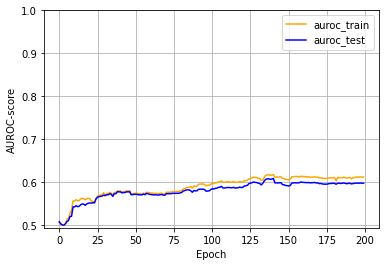

In [ ]:
import matplotlib.pyplot as plt

x = range(num_epochs)
plt.clf()
plt.plot(x, perf_train, color='orange', label='auroc_train')
plt.plot(x, perf_test, color='blue', label='auroc_test')
plt.xlabel('Epoch')
plt.ylabel('AUROC-score')
plt.legend()
plt.ylim(top=1)
plt.grid()
plt.show()
#plt.clf()

In [48]:
test_data = HeteroData()
for triple in complete_data.edge_index_dict.keys():
    for triple2 in complete_data.edge_index_dict.keys():
        test_data[triple2].edge_index = torch.Tensor([[],[]]).long()
        test_data[triple2[0]].x = torch.Tensor([[1]])
        if triple2[2] == 'String':
            test_data[triple2[2]].x = torch.Tensor([[1, 1, 1, 1, 1]])
        else:
            test_data[triple2[2]].x = torch.Tensor([[1]])

    test_data[triple[0]].x = torch.Tensor([[1]])
    
    if triple[2] == 'String':
        test_data[triple[2]].x = torch.Tensor([[1, 1, 1, 1, 1]])
    else:
        test_data[triple[2]].x = torch.Tensor([[1]])
        
    test_data[triple].edge_index = torch.Tensor([[0],[0]]).long()
    weight = test_hetscores(model, test_data)[0]
    print(f'{triple}: {weight}')

AttributeError: 'EdgeStorage' object has no attribute 'edge_label_index'